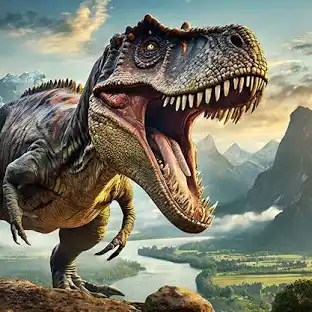




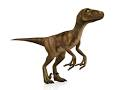



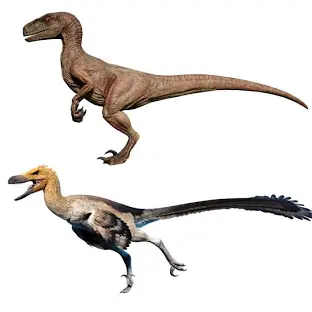

In [ ]:
import os
import numpy as np
import scipy as sp

In [ ]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Chemin vers le fichier texte dans Google Drive
file_path = "/content/drive/My Drive/dinos.txt"  # Remplacez par votre chemin exact

# Lire le fichier texte
with open(file_path, 'r') as file:
    data = file.read()

# Afficher le contenu du fichier
print(data)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Aachenosaurus
Aardonyx
Abdallahsaurus
Abelisaurus
Abrictosaurus
Abrosaurus
Abydosaurus
Acanthopholis
Achelousaurus
Acheroraptor
Achillesaurus
Achillobator
Acristavus
Acrocanthosaurus
Acrotholus
Actiosaurus
Adamantisaurus
Adasaurus
Adelolophus
Adeopapposaurus
Aegyptosaurus
Aeolosaurus
Aepisaurus
Aepyornithomimus
Aerosteon
AetonyxAfromimus
Afrovenator
Agathaumas
Aggiosaurus
Agilisaurus
Agnosphitys
Agrosaurus
Agujaceratops
Agustinia
Ahshislepelta
Airakoraptor
Ajancingenia
Ajkaceratops
Alamosaurus
Alaskacephale
Albalophosaurus
Albertaceratops
Albertadromeus
Albertavenator
Albertonykus
Albertosaurus
Albinykus
Albisaurus
Alcovasaurus
Alectrosaurus
Aletopelta
Algoasaurus
Alioramus
Aliwalia
Allosaurus
Almas
Alnashetri
Alocodon
Altirhinus
Altispinax
Alvarezsaurus
Alwalkeria
Alxasaurus
Amargasaurus
Amargastegos
Amargatitanis
Amazonsaurus
Ammosaurus
Ampelosaurus
Amphico

Data Preparation


In [ ]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Classe DataGenerator
import numpy as np

class DataGenerator:
    """
    A class for generating input and output examples for a character-level language model.
    """

    def __init__(self, path):
        """
        Initializes a DataGenerator object.

        Args:
            path (str): The path to the text file containing the training data.
        """
        self.path = path

        # Read in data from file and convert to lowercase
        with open(path) as f:
            data = f.read().lower()

        # Create list of unique characters in the data
        self.chars = list(set(data))

        # Create dictionaries mapping characters to and from their index in the list of unique characters
        self.char_to_idx = {ch: i for (i, ch) in enumerate(self.chars)}
        self.idx_to_char = {i: ch for (i, ch) in enumerate(self.chars)}

        # Set the size of the vocabulary (i.e. number of unique characters)
        self.vocab_size = len(self.chars)

        # Read in examples from file and convert to lowercase, removing leading/trailing white space
        with open(path) as f:
            examples = f.readlines()
        self.examples = [x.lower().strip() for x in examples]

    def generate_example(self, idx):
        """
        Generates an input/output example for the language model based on the given index.

        Args:
            idx (int): The index of the example to generate.

        Returns:
            A tuple containing the input and output arrays for the example.
        """
        example_chars = self.examples[idx]

        # Convert the characters in the example to their corresponding indices in the list of unique characters
        example_char_idx = [self.char_to_idx[char] for char in example_chars]

        # Add newline character as the first character in the input array, and as the last character in the output array
        X = [self.char_to_idx['\n']] + example_char_idx
        Y = example_char_idx + [self.char_to_idx['\n']]

        return np.array(X), np.array(Y)

# Chemin vers le fichier dinos.txt
data_path = "/content/drive/My Drive/dinos.txt"  # Remplacez par votre chemin exact si nécessaire

# Initialiser DataGenerator avec dinos.txt
data_gen = DataGenerator(data_path)

# Générer un exemple à partir des données
X, Y = data_gen.generate_example(0)
print("Input Indices:", X)
print("Output Indices:", Y)

# Vérifiez les caractères correspondants
print("Input Characters:", [data_gen.idx_to_char[i] for i in X])
print("Output Characters:", [data_gen.idx_to_char[i] for i in Y])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input Indices: [17 13 13  7 25  2 21 11 10 13 16 23 16 10]
Output Indices: [13 13  7 25  2 21 11 10 13 16 23 16 10 17]
Input Characters: ['\n', 'a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's']
Output Characters: ['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '\n']


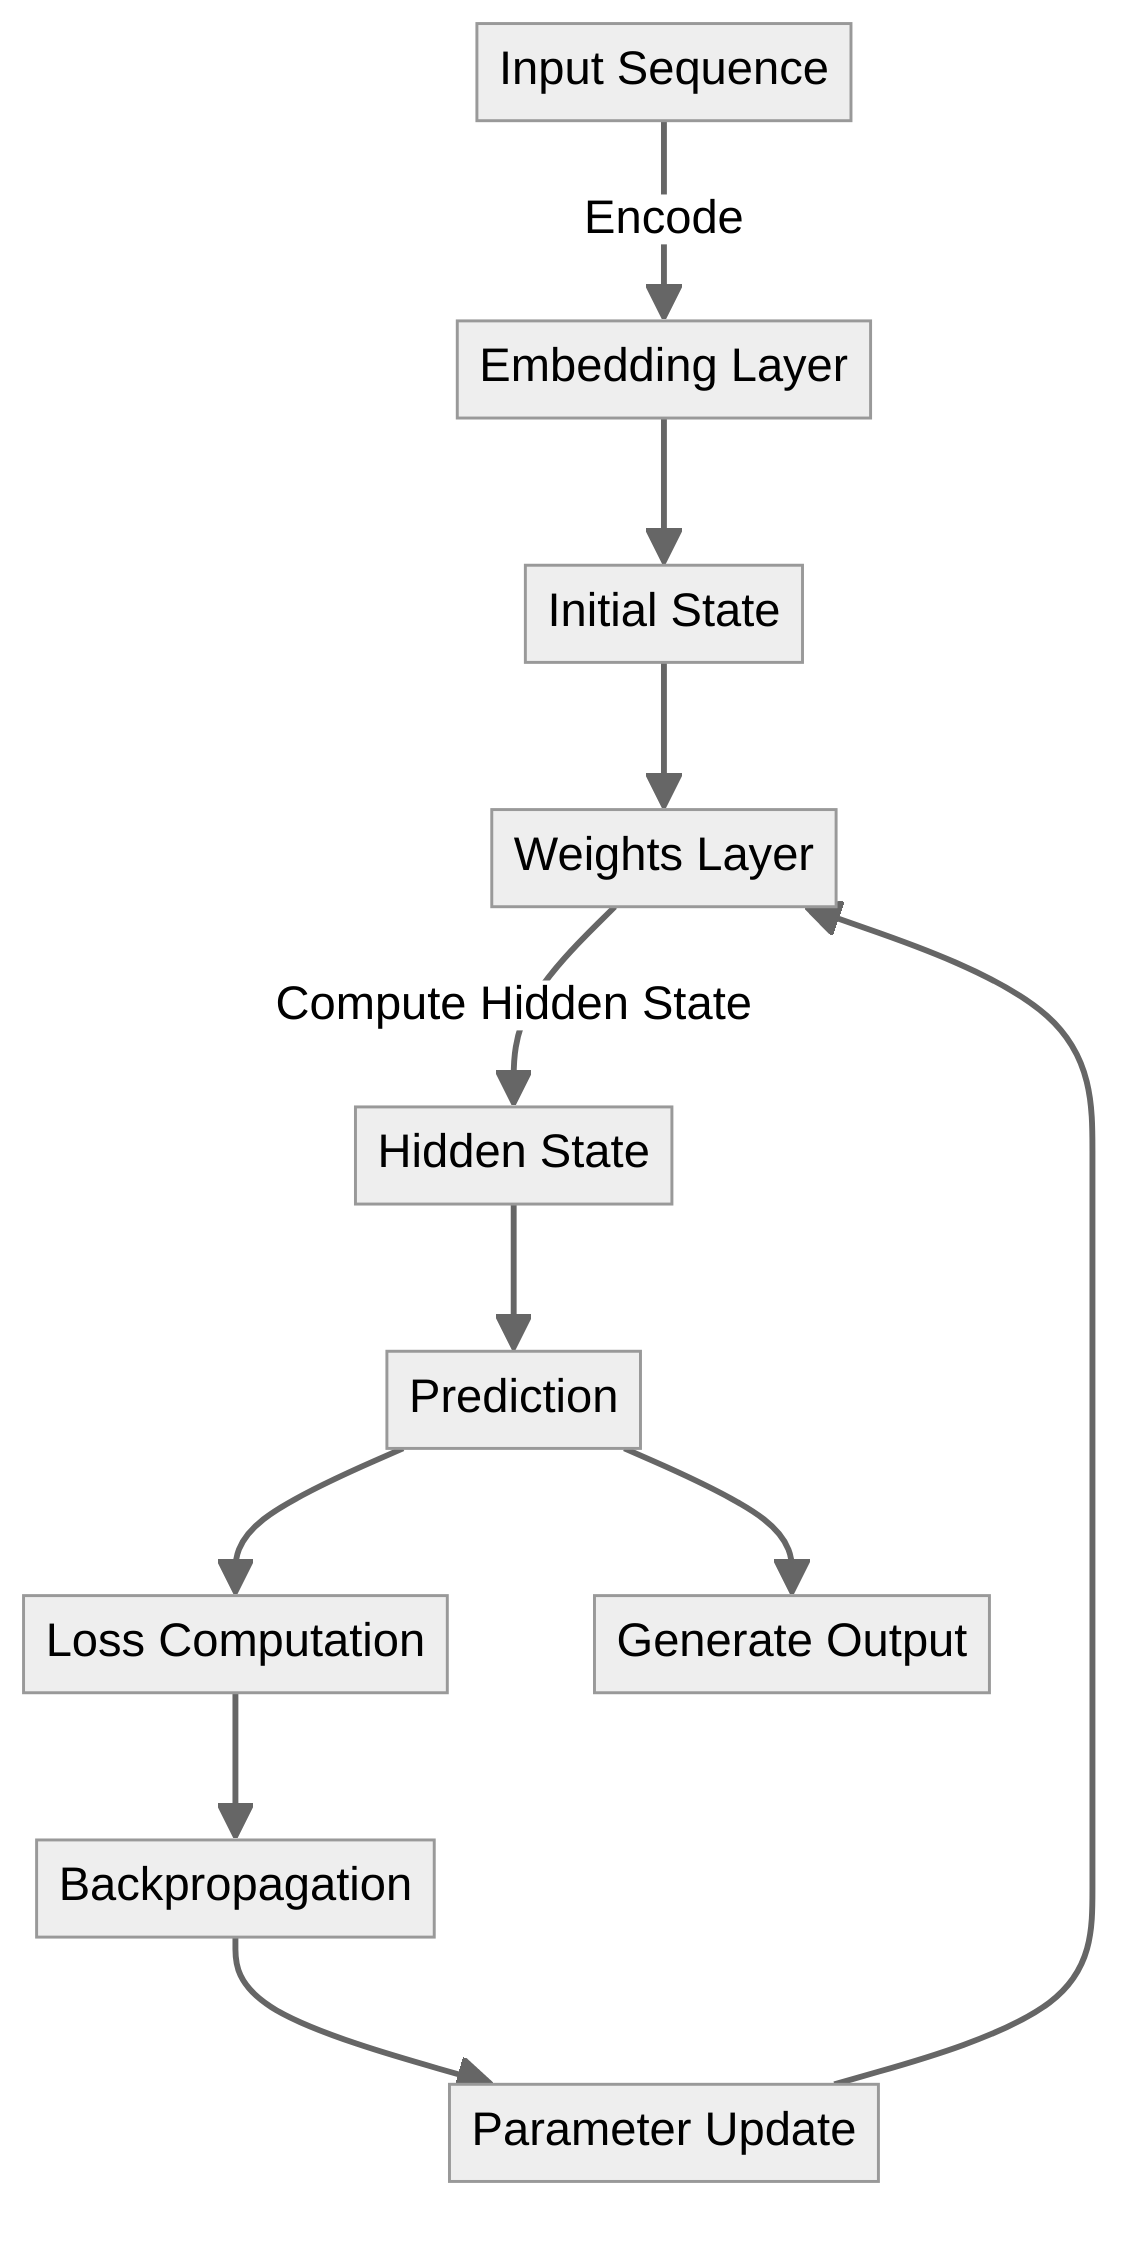

RNN Implementation


In [ ]:
class RNN:
    """
    A class used to represent a Recurrent Neural Network (RNN).

    Attributes
    ----------
    hidden_size : int
        The number of hidden units in the RNN.
    vocab_size : int
        The size of the vocabulary used by the RNN.
        Le vocab_size représente la taille du vocabulaire, c’est-à-dire le nombre total d’éléments uniques (mots, caractères ou symboles) que le modèle peut comprendre et traiter.
    sequence_length : int
        The length of the input sequences fed to the RNN.
        Nombre d'éléments dans une séquence individuelle.
    learning_rate : float
        The learning rate used during training.
    is_initialized : bool
        Indicates whether the AdamW parameters has been initialized.

    Methods
    -------
    __init__(hidden_size, vocab_size, sequence_length, learning_rate)
        Initializes an instance of the RNN class.

    forward(self, X, a_prev)
     Computes the forward pass of the RNN.

    softmax(self, x)
       Computes the softmax activation function for a given input array.

    backward(self,x, a, y_preds, targets)
        Implements the backward pass of the RNN.

   loss(self, y_preds, targets)
     Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

    adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4)
       Updates the RNN's parameters using the AdamW optimization algorithm.

    train(self, generated_names=5)
       Trains the RNN on a dataset using backpropagation through time (BPTT).

   predict(self, start)
        Generates a sequence of characters using the trained self, starting from the given start sequence.
        The generated sequence may contain a maximum of 50 characters or a newline character.

    """

    def __init__(self, hidden_size, data_generator, sequence_length, learning_rate):
        """
        Initializes an instance of the RNN class.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the RNN.
        vocab_size : int
            The size of the vocabulary used by the RNN.
        sequence_length : int
            The length of the input sequences fed to the RNN.
        learning_rate : float
            The learning rate used during training.
        """

        # hyper parameters
        self.hidden_size = hidden_size
        self.data_generator = data_generator
        self.vocab_size = self.data_generator.vocab_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate
        self.X = None

        # model parameters
        self.Wax = np.random.uniform(-np.sqrt(1. / self.vocab_size), np.sqrt(1. / self.vocab_size), (hidden_size, self.vocab_size))
        self.Waa = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (hidden_size, hidden_size))
        self.Wya = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (self.vocab_size, hidden_size))
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((self.vocab_size, 1))

        # Initialize gradients
        self.dWax, self.dWaa, self.dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        self.dba, self.dby = np.zeros_like(self.ba), np.zeros_like(self.by)

        # parameter update with AdamW
        self.mWax = np.zeros_like(self.Wax)
        self.vWax = np.zeros_like(self.Wax)
        self.mWaa = np.zeros_like(self.Waa)
        self.vWaa = np.zeros_like(self.Waa)
        self.mWya = np.zeros_like(self.Wya)
        self.vWya = np.zeros_like(self.Wya)
        self.mba = np.zeros_like(self.ba)
        self.vba = np.zeros_like(self.ba)
        self.mby = np.zeros_like(self.by)
        self.vby = np.zeros_like(self.by)

    def softmax(self, x):
        """
        Computes the softmax activation function for a given input array.

        Parameters:
            x (ndarray): Input array.

        Returns:
            ndarray: Array of the same shape as `x`, containing the softmax activation values.
        """
        # shift the input to prevent overflow when computing the exponentials
        x = x - np.max(x)
        # compute the exponentials of the shifted input
        p = np.exp(x)
        # normalize the exponentials by dividing by their sum
        return p / np.sum(p)

    def forward(self, X, a_prev):
        """
        Compute the forward pass of the RNN.

        Parameters:
        X (ndarray): Input data of shape (seq_length, vocab_size)
        a_prev (ndarray): Activation of the previous time step of shape (hidden_size, 1)

        Returns:
        x (dict): Dictionary of input data of shape (seq_length, vocab_size, 1), with keys from 0 to seq_length-1
        a (dict): Dictionary of hidden activations for each time step, with keys from 0 to seq_length-1
        y_pred (dict): Dictionary of output probabilities for each time step, with keys from 0 to seq_length-1

        Paramètres :
        X (ndarray) : Données d'entrée de forme (seq_length, vocab_size)
        a_prev (ndarray) : Activation du pas de temps précédent de forme (hidden_size, 1)

        Renvoie :
        x (dict) : Dictionnaire des données d'entrée de forme (seq_length, vocab_size, 1), avec des clés de 0 à seq_length-1
        a (dict) : Dictionnaire des activations cachées pour chaque pas de temps, avec des clés de 0 à seq_length-1
        y_pred (dict) : Dictionnaire des probabilités de sortie pour chaque pas de temps, avec des clés de 0 à seq_length-1
        """
        # Initialize dictionaries to store activations and output probabilities.
        x, a, y_pred = {}, {}, {}

        # Store the input data in the class variable for later use in the backward pass.
        self.X = X

        # Set the initial activation to the previous activation.
        a[-1] = np.copy(a_prev)
        # iterate over each time step in the input sequence
        for t in range(len(self.X)):
            # get the input at the current time step
            x[t] = np.zeros((self.vocab_size,1))#(veteur mencodi dial x(t)) #vecteur en hot encoding
            if (self.X[t] != None):
                x[t][self.X[t]] = 1
            # compute the hidden activation at the current time step
            a[t] = np.tanh(np.dot(self.Wax, x[t]) + np.dot(self.Waa, a[t - 1]) + self.ba)
            #np.dot(A, B) calcule :
           # Le produit scalaire si AA et BB sont des vecteurs 1D (tableaux d'une seule dimension).
           # La multiplication matricielle si AA et BB sont des matrices (tableaux 2D).
   # Si AA ou BB a plus de deux dimensions, il applique les règles spécifiques de contraction de tenseurs.
            # a[t]=tanh(Wax​x[t]+Waa​a[t−1]+ba​)
            # compute the output probabilities at the current time step
            y_pred[t] = self.softmax(np.dot(self.Wya, a[t]) + self.by)
            # add an extra dimension to X to make it compatible with the shape of the input to the backward pass
         # return the input, hidden activations, and output probabilities at each time step
        return x, a, y_pred

    def backward(self,x, a, y_preds, targets):
        """
        Implement the backward pass of the RNN.

        Args:
        x -- (dict) of input characters (as one-hot encoding vectors) for each time-step, shape (vocab_size, sequence_length)
        a -- (dict) of hidden state vectors for each time-step, shape (hidden_size, sequence_length)
        y_preds -- (dict) of output probability vectors (after softmax) for each time-step, shape (vocab_size, sequence_length)
        targets -- (list) of integer target characters (indices of characters in the vocabulary) for each time-step, shape (1, sequence_length)
        Implémenter le passage arrière du RNN.

         Args :
         x -- (dict) des caractères d'entrée (en tant que vecteurs d'encodage one-hot) pour chaque pas de temps, forme (vocab_size, sequence_length)
         a -- (dict) des vecteurs d'état cachés pour chaque pas de temps, forme (hidden_size, sequence_length)
         y_preds -- (dict) des vecteurs de probabilité de sortie (après softmax) pour chaque pas de temps, forme (vocab_size, sequence_length)
        target -- (liste) des caractères cibles entiers (indices de caractères dans le vocabulaire) pour chaque pas de temps, forme (1, sequence_length)


        Returns:
        None

        """
        # Initialize derivative of hidden state for the last time-step
        da_next = np.zeros_like(a[0])

        # Loop through the input sequence backwards
        for t in reversed(range(len(self.X))):
            # Calculate derivative of output probability vector
            dy_preds = np.copy(y_preds[t])
            dy_preds[targets[t]] -= 1

            # Calculate derivative of hidden state
            da = np.dot(self.Waa.T, da_next) + np.dot(self.Wya.T, dy_preds)
            dtanh = (1 - np.power(a[t], 2))
            da_unactivated = dtanh * da

            # Calculate gradients
            self.dba += da_unactivated
            self.dWax += np.dot(da_unactivated, x[t].T)
            self.dWaa += np.dot(da_unactivated, a[t - 1].T)

            # Update derivative of hidden state for the next iteration
            da_next = da_unactivated

            # Calculate gradient for output weight matrix
            self.dWya += np.dot(dy_preds, a[t].T)

            # clip gradients to avoid exploding gradients
            for grad in [self.dWax, self.dWaa, self.dWya, self.dba, self.dby]:
                np.clip(grad, -1, 1, out=grad)
            #Empêche les gradients de devenir trop grands (ce qui pourrait déstabiliser l'apprentissage).
            #Les valeurs des gradients sont limitées dans l'intervalle [-1, 1].

    def loss(self, y_preds, targets):
        """
        Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

        Parameters:
            y_preds (ndarray): Array of shape (sequence_length, vocab_size) containing the predicted probabilities for each time step.
            targets (ndarray): Array of shape (sequence_length, 1) containing the true targets for each time step.

        Returns:
            float: Cross-entropy loss.
        """
        # calculate cross-entropy loss
        return sum(-np.log(y_preds[t][targets[t], 0]) for t in range(len(self.X)))

    def adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4):
        """
        Updates the RNN's parameters using the AdamW optimization algorithm.
        """

      # Mise à jour de la moyenne mobile des gradients (mtmt​) :
        #mt=β1mt−1+(1−β1)dWax
        #mt​=β1​mt−1​+(1−β1​)dWax​

      # Mise à jour de la moyenne mobile du carré des gradients (vtvt​) :
         #vt=β2vt−1+(1−β2)(dWax)2
         #vt​=β2​vt−1​+(1−β2​)(dWax​)2
        # AdamW update for Wax


        self.mWax = beta1 * self.mWax + (1 - beta1) * self.dWax
        self.vWax = beta2 * self.vWax + (1 - beta2) * np.square(self.dWax)
        m_hat = self.mWax / (1 - beta1)
        v_hat = self.vWax / (1 - beta2)
        self.Wax -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wax)

        # AdamW update for Waa
        self.mWaa = beta1 * self.mWaa + (1 - beta1) * self.dWaa
        self.vWaa = beta2 * self.vWaa + (1 - beta2) * np.square(self.dWaa)
        m_hat = self.mWaa / (1 - beta1)
        v_hat = self.vWaa / (1 - beta2)
        self.Waa -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Waa)

        # AdamW update for Wya
        self.mWya = beta1 * self.mWya + (1 - beta1) * self.dWya
        self.vWya = beta2 * self.vWya + (1 - beta2) * np.square(self.dWya)
        m_hat = self.mWya / (1 - beta1)
        v_hat = self.vWya / (1 - beta2)
        self.Wya -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wya)

        # AdamW update for ba
        self.mba = beta1 * self.mba + (1 - beta1) * self.dba
        self.vba = beta2 * self.vba + (1 - beta2) * np.square(self.dba)
        m_hat = self.mba / (1 - beta1)
        v_hat = self.vba / (1 - beta2)
        self.ba -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.ba)

        # AdamW update for by
        self.mby = beta1 * self.mby + (1 - beta1) * self.dby
        self.vby = beta2 * self.vby + (1 - beta2) * np.square(self.dby)

    def sample(self):
        """
        Sample a sequence of characters from the RNN.

        Args:
            None

        Returns:
            list: A list of integers representing the generated sequence.
        """
        # initialize input and hidden state
        x = np.zeros((self.vocab_size, 1))
        a_prev = np.zeros((self.hidden_size, 1))

        # create an empty list to store the generated character indices
        indices = []

        # idx is a flag to detect a newline character, initialize it to -1
        idx = -1

        # generate sequence of characters
        counter = 0
        max_chars = 50 # maximum number of characters to generate
        newline_character = self.data_generator.char_to_idx['\n'] # the newline character

        while (idx != newline_character and counter != max_chars):
            # compute the hidden state
            a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)#[-1,1]

            # compute the output probabilities
            y = self.softmax(np.dot(self.Wya, a) + self.by)

            # sample the next character from the output probabilities
            idx = np.random.choice(list(range(self.vocab_size)), p=y.ravel())

            # set the input for the next time step
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            # store the sampled character index in the list
            indices.append(idx)

            # update the previous hidden state
            a_prev = a

            # increment the counter
            counter += 1

        # return the list of sampled character indices
        return indices


    def train(self, generated_names=5):
        """
        Train the RNN on a dataset using backpropagation through time (BPTT).

        Args:
        - generated_names: an integer indicating how many example names to generate during training.

        Returns:
        - None
        """

        iter_num = 0
        threshold = 5 # stopping criterion for training
        smooth_loss = -np.log(1.0 / self.data_generator.vocab_size) * self.sequence_length  # initialize loss

        while (smooth_loss > threshold):
            # threshold :
             #Une valeur seuil fixée par l'utilisateur pour arrêter l'entraînement lorsque le modèle est suffisamment performant.
            a_prev = np.zeros((self.hidden_size, 1))
            idx = iter_num % self.vocab_size
            # get a batch of inputs and targets
            inputs, targets = self.data_generator.generate_example(idx)

            # forward pass
            x, a, y_pred  = self.forward(inputs, a_prev)

            # backward pass
            self.backward(x, a, y_pred, targets)

            # calculate and update loss
            loss = self.loss(y_pred, targets)
            self.adamw()
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # update previous hidden state for the next batch
            a_prev = a[len(self.X) - 1]
            # print progress every 500 iterations
            if iter_num % 500 == 0:
                print("\n\niter :%d, loss:%f\n" % (iter_num, smooth_loss))
                for i in range(generated_names):
                    sample_idx = self.sample()
                    txt = ''.join(self.data_generator.idx_to_char[idx] for idx in sample_idx)
                    txt = txt.title()  # capitalize first character
                    print ('%s' % (txt, ), end='')
            iter_num += 1

    def predict(self, start):
        """
        Generate a sequence of characters using the trained self, starting from the given start sequence.
        The generated sequence may contain a maximum of 50 characters or a newline character.

        Args:
        - start: a string containing the start sequence

        Returns:
        - txt: a string containing the generated sequence
        """

        # Initialize input vector and previous hidden state
        x = np.zeros((self.vocab_size, 1))
        a_prev = np.zeros((self.hidden_size, 1))

        # Convert start sequence to indices
        chars = [ch for ch in start]
        idxes = []
        for i in range(len(chars)):
            idx = self.data_generator.char_to_idx[chars[i]]
            x[idx] = 1
            idxes.append(idx)

        # Generate sequence
        max_chars = 50  # maximum number of characters to generate
        newline_character = self.data_generator.char_to_idx['\n']  # the newline character
        counter = 0
        while (idx != newline_character and counter != max_chars):
            # Compute next hidden state and predicted character
            a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)
            y_pred = self.softmax(np.dot(self.Wya, a) + self.by)
            idx = np.random.choice(range(self.vocab_size), p=y_pred.ravel())

            # Update input vector, previous hidden state, and indices
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
            a_prev = a
            idxes.append(idx)
            counter += 1

        # Convert indices to characters and concatenate into a string
        txt = ''.join(self.data_generator.idx_to_char[i] for i in idxes)

        # Remove newline character if it exists at the end of the generated sequence
        if txt[-1] == '\n':
            txt = txt[:-1]

        return txt

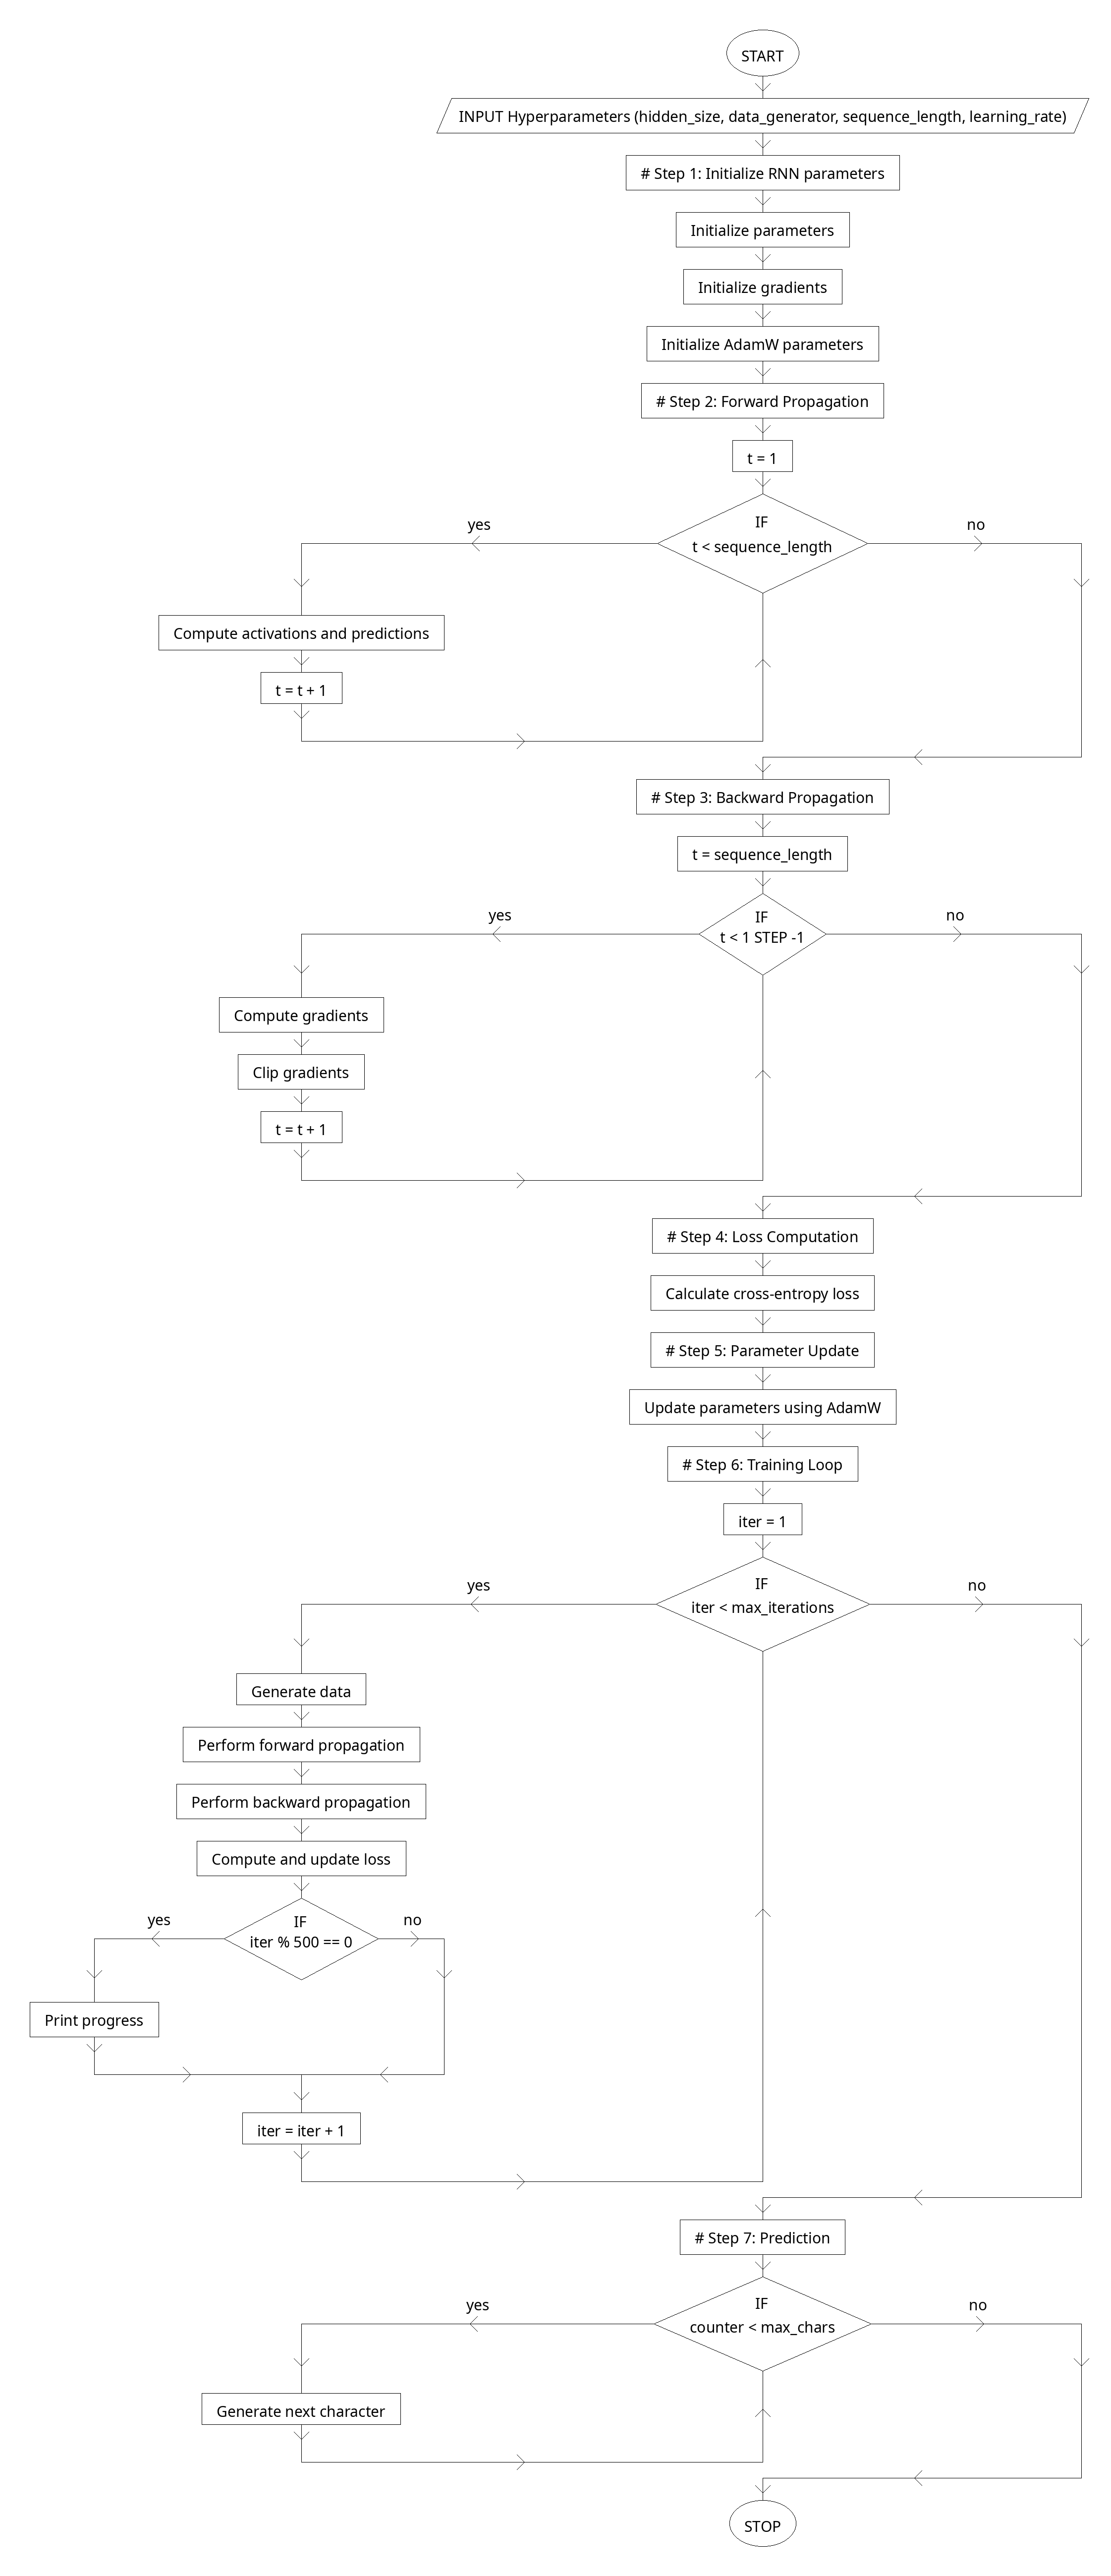

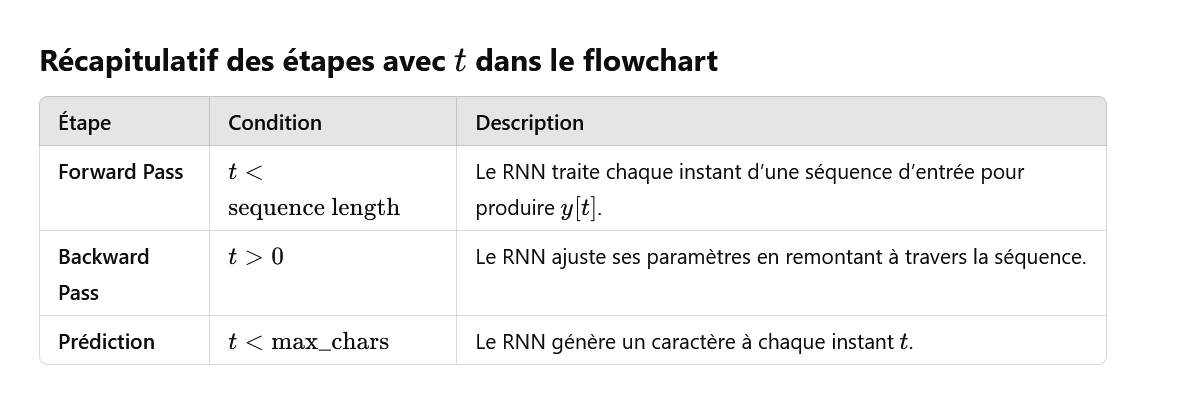


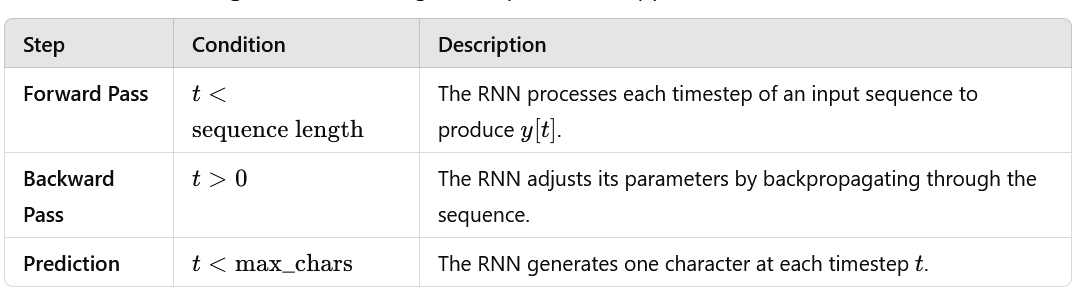

In [ ]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importer les bibliothèques nécessaires
import numpy as np

# Initialisation de la classe DataGenerator
data_generator = DataGenerator('/content/drive/My Drive/dinos.txt')  # Remplacez par le chemin réel si différent

# Initialisation du RNN
rnn = RNN(
    hidden_size=200,                # Nombre d'unités cachées
    data_generator=data_generator,  # Générateur de données
    sequence_length=25,             # Longueur des séquences d'entrée
    learning_rate=1e-3              # Taux d'apprentissage
)

# Entraînement du modèle
rnn.train()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


iter :0, loss:82.359818

XywasubdwdyxyzibhgqcyvgejsyzonnhhjwcqdqcvhslgffewaHexvldgcstsmwovxixbknwzxedde
Cobpttllgucvdzbbkzhhypxssjf
Jzwizh
Xexgmsfclodobertybfsxfhksalgyftjckxhrrtloyvupjzfqg

iter :500, loss:59.547894


Aueypvaoaorus
Mcnnlametmsaurus
Gyrjlrnhprueahaurusaurus



iter :1000, loss:42.549679

Achitausaurum
Aarltlaos
Aaadonyfrus
Ayaovhsaurus
Arrontsrus


iter :1500, loss:30.454639

Accintorhsauris
Aaosamoolaus
Abrypenibsaurus
Vopaellisaurus
Aepyd


iter :2000, loss:22.019382

Achitholes
Acreteopholos
Craetolis
Afrosaurus
Itddonyx


iter :2500, loss:16.172767

Aleaveochelimimmmum
Adasaurus
Acroolophus
Aeolelahhosaurus
Abeliathomimis


iter :3000, loss:12.288096

Alconyxaurus
Aeolesaurus
Aapdosaurus
Alponyxafromimus
Acrovenitor


iter :3500, loss:9.653612

Abydosaurus
Adeopapposaurus
Aleaanyx
Acrothophorosaurus
Abelantorafromimus


iter :4000, loss

In [ ]:
rnn.predict("meo")

'meonatooisaurus'

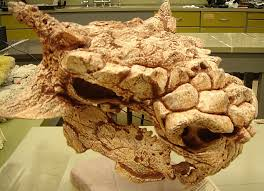

In [ ]:
rnn.predict("a")

'avzothopholis'